In [1]:
import cv2
import numpy as np
import scanpy as sc
import anndata as ad
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import os
import traceback # For detailed error printing

# --------------------------------------------------------------------------
# Subsetting Function Definition (Using Percentage-based ROI)
# (Keep this function definition near the top)
# --------------------------------------------------------------------------

def subset_spatial_roi_percent(
    adata_path: str,
    output_path: str,
    roi_pct_coords: list, # Now expecting a list
    library_id: str = None
):
    """
    Subsets an AnnData object based on a rectangular ROI defined by percentages
    of the spatial coordinate range. Crops the image accordingly, adjusts
    coordinates, and saves to a new h5ad file.

    Args:
        adata_path: Path to the input h5ad file.
        output_path: Path to save the subsetted h5ad file.
        roi_pct_coords: List [x_min_pct, y_min_pct, x_max_pct, y_max_pct]
                        defining the ROI as fractions (0.0 to 1.0) of the
                        range of coordinates in adata.obsm['spatial'].
        library_id: Optional library ID if AnnData has multiple. Uses the first if None.
    """
    print(f"Processing {adata_path} for percentage ROI: {roi_pct_coords}...")
    try:
        # --- Load Data ---
        adata = ad.read_h5ad(adata_path)

        # Get library ID
        if library_id is None:
            if not adata.uns.get('spatial'):
                 raise KeyError("Cannot find 'spatial' key in adata.uns")
            library_id = list(adata.uns['spatial'].keys())[0]
            print(f"  Using library ID: {library_id}")
        elif library_id not in adata.uns.get('spatial', {}):
             raise KeyError(f"Provided library_id '{library_id}' not found in adata.uns['spatial']")

        # Extract spatial info
        spatial_info = adata.uns['spatial'][library_id]
        if 'hires' not in spatial_info.get('images', {}):
            raise KeyError(f"High-resolution image ('hires') not found for library '{library_id}'.")
        img = spatial_info['images']['hires']
        if 'spatial' not in adata.obsm:
            raise KeyError("Spatial coordinates ('spatial') not found in adata.obsm.")
        coords = adata.obsm['spatial'].copy()
        if 'scalefactors' not in spatial_info:
             raise KeyError(f"Scale factors ('scalefactors') not found for library '{library_id}'.")
        scalefactors = spatial_info['scalefactors']

        # --- Validate ROI Percentages ---
        if not isinstance(roi_pct_coords, list) or len(roi_pct_coords) != 4:
             raise ValueError("roi_pct_coords must be a list of 4 elements.")
        if not all(isinstance(p, (int, float)) and 0.0 <= p <= 1.0 for p in roi_pct_coords):
            raise ValueError("ROI percentages must be numbers between 0.0 and 1.0.")
        x_min_pct, y_min_pct, x_max_pct, y_max_pct = roi_pct_coords
        if x_min_pct >= x_max_pct or y_min_pct >= y_max_pct:
            raise ValueError("Invalid ROI percentages: min percentage >= max percentage.")

        # --- Calculate Coordinate Range and ROI Boundaries ---
        min_x_coord = np.min(coords[:, 0])
        max_x_coord = np.max(coords[:, 0])
        min_y_coord = np.min(coords[:, 1])
        max_y_coord = np.max(coords[:, 1])
        span_x = max_x_coord - min_x_coord
        span_y = max_y_coord - min_y_coord
        if span_x <= 0: span_x = 1
        if span_y <= 0: span_y = 1
        x_min_roi = min_x_coord + (x_min_pct * span_x)
        y_min_roi = min_y_coord + (y_min_pct * span_y)
        x_max_roi = min_x_coord + (x_max_pct * span_x)
        y_max_roi = min_y_coord + (y_max_pct * span_y)
        print(f"  Coordinate range (X): {min_x_coord:.2f} - {max_x_coord:.2f}")
        print(f"  Coordinate range (Y): {min_y_coord:.2f} - {max_y_coord:.2f}")
        print(f"  Calculated ROI coordinates: X({x_min_roi:.2f}-{x_max_roi:.2f}), Y({y_min_roi:.2f}-{y_max_roi:.2f})")

        # --- Filter Spots within ROI ---
        spot_x = coords[:, 0]
        spot_y = coords[:, 1]
        in_roi_mask = (
            (spot_x >= x_min_roi) & (spot_x < x_max_roi) &
            (spot_y >= y_min_roi) & (spot_y < y_max_roi)
        )
        n_spots_in_roi = np.sum(in_roi_mask)
        print(f"  Found {n_spots_in_roi} spots within the ROI.")
        if n_spots_in_roi == 0:
            print("  Warning: No spots found within the defined ROI. Skipping file save.")
            return # Don't save if no spots

        # --- Create Subset AnnData ---
        subset_adata = adata[in_roi_mask, :].copy()

        # --- Determine Pixel Boundaries for Cropping ---
        img_h, img_w = img.shape[:2]
        x_min_px = max(0, int(np.floor(x_min_roi)))
        y_min_px = max(0, int(np.floor(y_min_roi)))
        x_max_px = min(img_w, int(np.ceil(x_max_roi)))
        y_max_px = min(img_h, int(np.ceil(y_max_roi)))
        if x_min_px >= x_max_px or y_min_px >= y_max_px:
             print(f"  Warning: Calculated pixel ROI [{x_min_px}:{x_max_px}, {y_min_px}:{y_max_px}] is invalid after clipping. Skipping save.")
             return # Don't save if crop is invalid
        print(f"  Determined Pixel Crop ROI: X({x_min_px}-{x_max_px}), Y({y_min_px}-{y_max_px})")

        # --- Crop Image ---
        cropped_img = img[y_min_px:y_max_px, x_min_px:x_max_px].copy()
        print(f"  Cropped image dimensions (height, width): {cropped_img.shape[:2]}")
        if cropped_img.size == 0:
             print("  Warning: Cropped image is empty. Skipping save.")
             return # Don't save if image is empty

        # --- Adjust Spatial Coordinates ---
        original_subset_coords = subset_adata.obsm['spatial']
        adjusted_coords = original_subset_coords - np.array([x_min_px, y_min_px])
        subset_adata.obsm['spatial'] = adjusted_coords

        # --- Update AnnData Structure ---
        subset_adata.uns['spatial'] = {}
        subset_adata.uns['spatial'][library_id] = {}
        subset_adata.uns['spatial'][library_id]['images'] = {'hires': cropped_img}
        subset_adata.uns['spatial'][library_id]['scalefactors'] = scalefactors.copy()
        metadata = {
            'crop_roi_percent': list(roi_pct_coords), # Keep as list
            'calculated_coord_roi': [x_min_roi, y_min_roi, x_max_roi, y_max_roi],
            'calculated_pixel_roi_clipped': [x_min_px, y_min_px, x_max_px, y_max_px],
            'original_library_id': library_id,
            'source_file': os.path.basename(adata_path)
        }
        if 'metadata' in spatial_info:
             original_meta = spatial_info['metadata'].copy()
             for key in metadata:
                 original_meta.pop(key, None)
             metadata.update(original_meta)
        subset_adata.uns['spatial'][library_id]['metadata'] = metadata

        # --- Save Subset AnnData ---
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        subset_adata.write(output_path, compression="gzip")
        print(f"  Successfully saved subsetted AnnData to: {output_path}")

    except FileNotFoundError:
        print(f"Error: Input file not found at {adata_path}")
    except (KeyError, ValueError) as e:
        print(f"Error processing {adata_path}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while processing {adata_path}: {e}")
        traceback.print_exc()


In [2]:
# --------------------------------------------------------------------------
# Configuration
# --------------------------------------------------------------------------
input_dir = "rotated_split_tissue_h5ad"
output_dir = "roi_subset_h5ad" # Choose your output directory name
# List the base filenames of your rotated input files
input_filenames = [
    "rotated_e14_spatial.h5ad",
    "rotated_e15_spatial.h5ad",
    "rotated_e16_spatial.h5ad",
]

# --- Create Output Directory ---
os.makedirs(output_dir, exist_ok=True)

# --------------------------------------------------------------------------
# Step 1: Load Original Rotated Data
# --------------------------------------------------------------------------
print("\n--- Step 1: Loading Original Rotated AnnData objects ---")
original_adata_map = {}
original_adata_files = [] # Keep track of files successfully loaded

for filename in input_filenames:
    input_file_path = os.path.join(input_dir, filename)
    print(f"  Loading: {input_file_path}")
    if os.path.exists(input_file_path):
        try:
            adata = ad.read_h5ad(input_file_path)
            # --- Pre-calculate QC Metrics ---
            # Needed for plotting later, do it once here
            sc.pp.calculate_qc_metrics(adata)
            original_adata_map[filename] = adata
            original_adata_files.append(filename) # Add to list of successfully loaded
            print(f"    Loaded successfully. Shape: {adata.shape}")
        except Exception as e:
            print(f"    Error loading {filename}: {e}")
            traceback.print_exc()
    else:
        print(f"    Warning: File not found. Skipping.")

if not original_adata_map:
    print("\nError: No original AnnData objects were loaded. Exiting.")
    exit()



--- Step 1: Loading Original Rotated AnnData objects ---
  Loading: rotated_split_tissue_h5ad/rotated_e14_spatial.h5ad
    Loaded successfully. Shape: (62389, 19059)
  Loading: rotated_split_tissue_h5ad/rotated_e15_spatial.h5ad
    Loaded successfully. Shape: (74479, 19059)
  Loading: rotated_split_tissue_h5ad/rotated_e16_spatial.h5ad
    Loaded successfully. Shape: (78697, 19059)



--- Step 2: Displaying Original Data for ROI Definition ---
    (Inspect this plot to help define your ROI percentages below)
  Plotting original: rotated_e14_spatial.h5ad
  Plotting original: rotated_e15_spatial.h5ad
  Plotting original: rotated_e16_spatial.h5ad


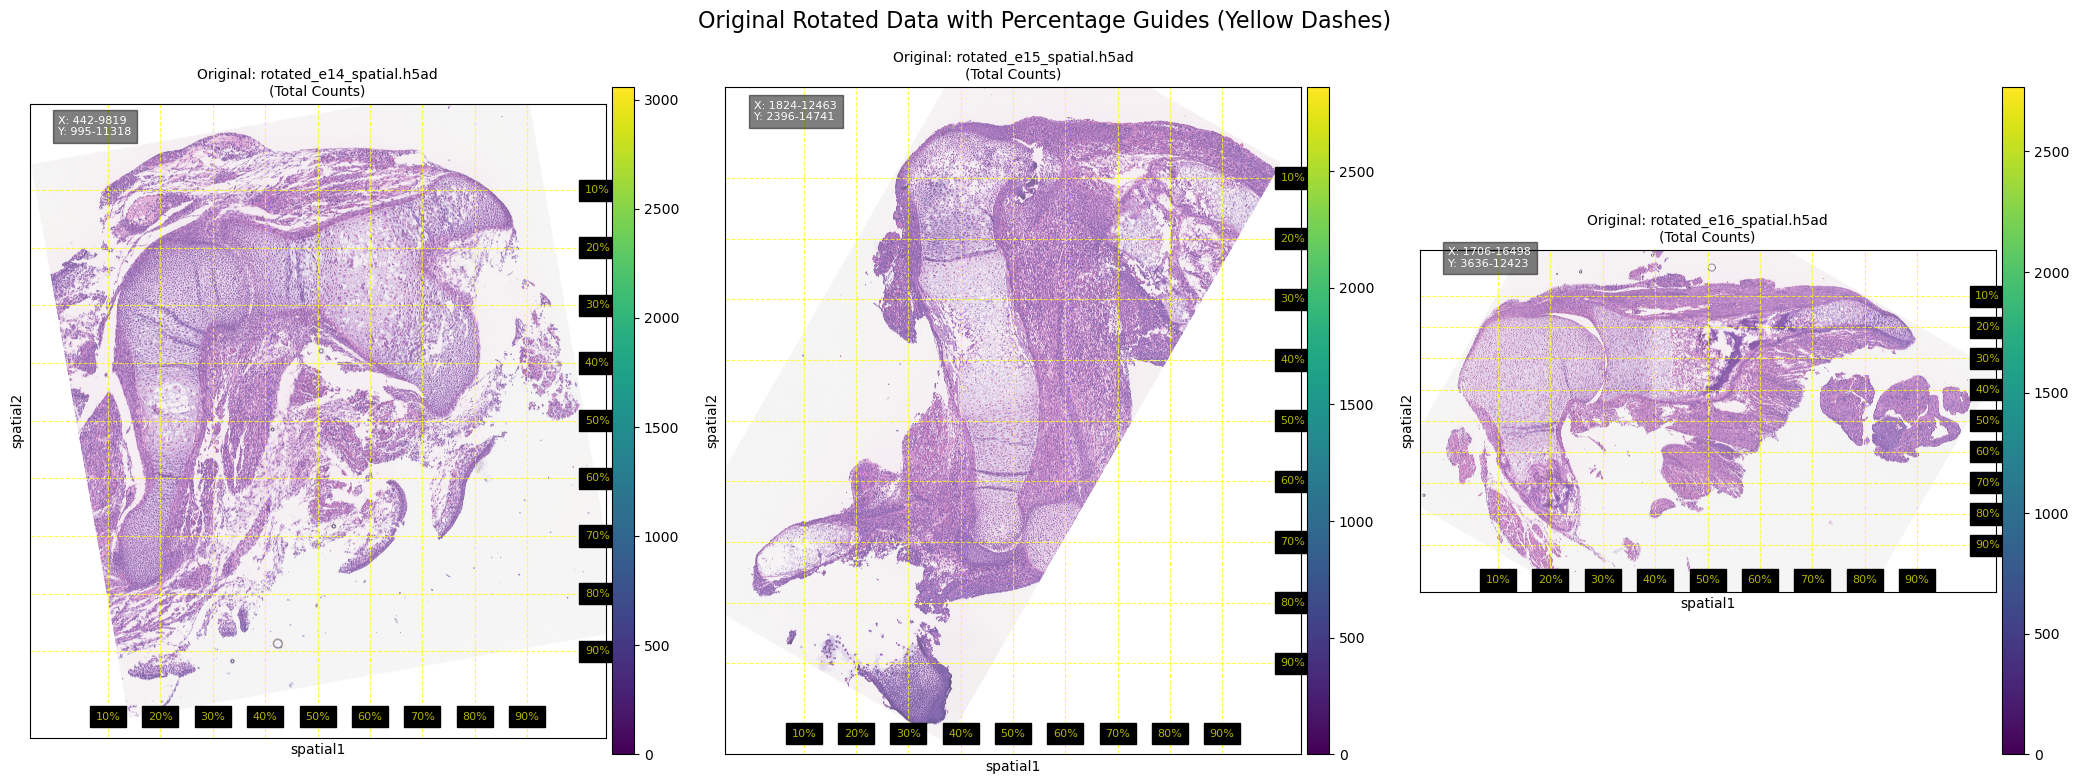

In [3]:
# 修改Step2的绘图部分，添加以下内容：

# --------------------------------------------------------------------------
# Step 2: Plot Original Data for ROI Inspection (修改后版本)
# --------------------------------------------------------------------------
print("\n--- Step 2: Displaying Original Data for ROI Definition ---")
print("    (Inspect this plot to help define your ROI percentages below)")

num_plots_orig = len(original_adata_map)
if num_plots_orig > 0:
    ncols_orig = num_plots_orig
    nrows_orig = 1
    fig_width_orig = 7 * ncols_orig
    fig_height_orig = 8
    fig_orig, axes_orig = plt.subplots(nrows_orig, ncols_orig, figsize=(fig_width_orig, fig_height_orig), squeeze=False)
    axes_orig = axes_orig.flatten()

    for i, filename in enumerate(original_adata_files):
        ax = axes_orig[i]
        adata_orig = original_adata_map[filename]
        print(f"  Plotting original: {filename}")

        try:
            # 获取空间信息
            library_id_orig = list(adata_orig.uns['spatial'].keys())[0]
            spatial_info = adata_orig.uns['spatial'][library_id_orig]
            
            # 绘制原始图像和点
            sc.pl.spatial(
                adata_orig,
                color=["total_counts"],
                library_id=library_id_orig,
                img_key='hires',
                alpha_img=0.7,
                ax=ax,
                show=False,
                spot_size=0.7,
                title="",
                vmin=0
            )
            
            # 获取图像尺寸和坐标范围
            img_h, img_w = spatial_info['images']['hires'].shape[:2]
            coords = adata_orig.obsm['spatial']
            x_min, x_max = np.min(coords[:,0]), np.max(coords[:,0])
            y_min, y_max = np.min(coords[:,1]), np.max(coords[:,1])
            
            # === 新增部分：添加百分比标记 ===
            # X轴标记（横向百分比线）
            for pct in np.arange(0.1, 1.0, 0.1):
                x_pct = x_min + (x_max - x_min) * pct
                ax.axvline(x=x_pct, color='yellow', linestyle='--', linewidth=0.8, alpha=0.7)
                ax.text(x=x_pct, y=y_max*1.02, 
                        s=f'{int(pct*100)}%', 
                        color='yellow', fontsize=8, 
                        ha='center', va='bottom',
                        backgroundcolor='black', alpha=0.7)
            
            # Y轴标记（纵向百分比线）
            for pct in np.arange(0.1, 1.0, 0.1):
                y_pct = y_min + (y_max - y_min) * pct
                ax.axhline(y=y_pct, color='yellow', linestyle='--', linewidth=0.8, alpha=0.7)
                ax.text(x=x_max*1.01, y=y_pct, 
                        s=f'{int(pct*100)}%', 
                        color='yellow', fontsize=8, 
                        ha='left', va='center',
                        backgroundcolor='black', alpha=0.7)
            
            # 添加坐标范围说明
            ax.text(0.05, 0.95, 
                    f"X: {x_min:.0f}-{x_max:.0f}\nY: {y_min:.0f}-{y_max:.0f}", 
                    transform=ax.transAxes,
                    color='white', fontsize=8,
                    bbox=dict(facecolor='black', alpha=0.5))
            
            ax.set_title(f"Original: {filename}\n(Total Counts)", fontsize=10)

        except Exception as e:
            print(f"    Error plotting original {filename}: {e}")
            traceback.print_exc()
            ax.text(0.5, 0.5, f'Error plotting:\n{e}', ha='center', va='center', color='red', transform=ax.transAxes, wrap=True, fontsize=8)
            ax.set_title(filename + "\n(Plot Error)", fontsize=10)

    fig_orig.suptitle("Original Rotated Data with Percentage Guides (Yellow Dashes)", fontsize=16, y=0.99)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [25]:

# --------------------------------------------------------------------------
# Step 3: Define ROIs (EDIT THIS SECTION)
# --------------------------------------------------------------------------
print("\n--- Step 3: Defining Regions of Interest (ROI) ---")
print("    (Edit the dictionary below based on the plot from Step 2)")

# Define ROIs using PERCENTAGES [x_min_pct, y_min_pct, x_max_pct, y_max_pct]
# IMPORTANT: Use LISTS [], not tuples (), for the values!
# x: 0.0 (left) to 1.0 (right) of coordinate range
# y: 0.0 (top) to 1.0 (bottom) of coordinate range

roi_definitions_percent = {
    # --- >> EDIT THESE VALUES << ---
    "rotated_e14_spatial.h5ad": [0.145, 0.15, 0.29, 0.245], # Example: Upper-left portion
    "rotated_e15_spatial.h5ad": [0.33, 0.01, 0.48, 0.09], # Example: Top-right thin strip
    "rotated_e16_spatial.h5ad": [0.08, 0.13, 0.19, 0.24], # Example: Upper-left quadrant
    # --- >> END OF EDIT SECTION << ---
}

# --- Configuration for Subsetting ---
roi_method = 'percent' # Keep this as 'percent' if using the dictionary above
subset_function = subset_spatial_roi_percent
output_prefix = "roi_pct_"

print("    ROI definitions set:")
for fname, roi in roi_definitions_percent.items():
    print(f"      {fname}: {roi}")



--- Step 3: Defining Regions of Interest (ROI) ---
    (Edit the dictionary below based on the plot from Step 2)
    ROI definitions set:
      rotated_e14_spatial.h5ad: [0.145, 0.15, 0.29, 0.245]
      rotated_e15_spatial.h5ad: [0.33, 0.01, 0.48, 0.09]
      rotated_e16_spatial.h5ad: [0.08, 0.13, 0.19, 0.24]


In [26]:

# --------------------------------------------------------------------------
# Step 4: Perform Subsetting
# --------------------------------------------------------------------------
print("\n--- Step 4: Subsetting AnnData objects based on ROI ---")

subset_files_created = [] # Keep track of successfully created files

for filename, roi_params in roi_definitions_percent.items():
    # Check if this file was successfully loaded in Step 1
    if filename not in original_adata_map:
        print(f"  Skipping subsetting for {filename} (original file not loaded).")
        continue

    input_file = os.path.join(input_dir, filename) # Path to original file
    output_filename = f"{output_prefix}{filename}"
    output_file = os.path.join(output_dir, output_filename)

    print(f"\n  Subsetting: {filename}")
    print(f"    Input: {input_file}")
    print(f"    Output: {output_file}")
    print(f"    ROI Params: {roi_params}")

    try:
        # Get library ID from the already loaded original adata
        library_id_to_pass = list(original_adata_map[filename].uns['spatial'].keys())[0]

        # Call the subsetting function
        subset_function(input_file, output_file, roi_params, library_id=library_id_to_pass)

        # Check if output file was actually created (function might return early)
        if os.path.exists(output_file):
             subset_files_created.append((output_filename, output_file))

    except Exception as e:
        print(f"    An error occurred during subsetting call for {filename}: {e}")
        traceback.print_exc()

print("\nSubsetting process finished.")



--- Step 4: Subsetting AnnData objects based on ROI ---

  Subsetting: rotated_e14_spatial.h5ad
    Input: rotated_split_tissue_h5ad/rotated_e14_spatial.h5ad
    Output: roi_subset_h5ad/roi_pct_rotated_e14_spatial.h5ad
    ROI Params: [0.145, 0.15, 0.29, 0.245]
Processing rotated_split_tissue_h5ad/rotated_e14_spatial.h5ad for percentage ROI: [0.145, 0.15, 0.29, 0.245]...
  Coordinate range (X): 442.25 - 9819.24
  Coordinate range (Y): 994.96 - 11318.48
  Calculated ROI coordinates: X(1801.91-3161.58), Y(2543.49-3524.22)
  Found 1680 spots within the ROI.
  Determined Pixel Crop ROI: X(1801-3162), Y(2543-3525)
  Cropped image dimensions (height, width): (982, 1361)
  Successfully saved subsetted AnnData to: roi_subset_h5ad/roi_pct_rotated_e14_spatial.h5ad

  Subsetting: rotated_e15_spatial.h5ad
    Input: rotated_split_tissue_h5ad/rotated_e15_spatial.h5ad
    Output: roi_subset_h5ad/roi_pct_rotated_e15_spatial.h5ad
    ROI Params: [0.33, 0.01, 0.48, 0.09]
Processing rotated_split_tissu

In [27]:

# --------------------------------------------------------------------------
# Step 5: Load Subsetted Data
# --------------------------------------------------------------------------
print("\n--- Step 5: Loading Subsetted AnnData objects ---")
subset_adata_map = {}

if not subset_files_created:
    print("    No subset files were created or found. Skipping final check.")
else:
    for output_filename, output_file_path in subset_files_created:
        print(f"  Loading subset: {output_file_path}")
        if os.path.exists(output_file_path):
            try:
                adata_sub = ad.read_h5ad(output_file_path)
                # Optional: Calculate QC again if needed for plotting subset
                sc.pp.calculate_qc_metrics(adata_sub)
                subset_adata_map[output_filename] = adata_sub
                print(f"    Loaded successfully. Shape: {adata_sub.shape}")
            except Exception as e:
                print(f"    Error loading subset {output_filename}: {e}")
                traceback.print_exc()
        else:
            # This case should ideally not happen if subset_files_created is accurate
            print(f"    Warning: Subset file listed but not found: {output_file_path}")



--- Step 5: Loading Subsetted AnnData objects ---
  Loading subset: roi_subset_h5ad/roi_pct_rotated_e14_spatial.h5ad
    Loaded successfully. Shape: (1680, 19059)
  Loading subset: roi_subset_h5ad/roi_pct_rotated_e15_spatial.h5ad
    Loaded successfully. Shape: (1636, 19059)
  Loading subset: roi_subset_h5ad/roi_pct_rotated_e16_spatial.h5ad
    Loaded successfully. Shape: (1931, 19059)



--- Step 6: Displaying Subsetted Data (Multiple Views) ---

  Plotting Row 1/3: roi_pct_rotated_e14_spatial.h5ad
    View 0: Image + n_genes_by_counts
    View 1: Total Counts (No Image)
    View 2: Gene Tnn (No Image)
    View 3: Gene Tnmd (No Image)

  Plotting Row 2/3: roi_pct_rotated_e15_spatial.h5ad
    View 0: Image + n_genes_by_counts
    View 1: Total Counts (No Image)
    View 2: Gene Tnn (No Image)
    View 3: Gene Tnmd (No Image)

  Plotting Row 3/3: roi_pct_rotated_e16_spatial.h5ad
    View 0: Image + n_genes_by_counts
    View 1: Total Counts (No Image)
    View 2: Gene Tnn (No Image)
    View 3: Gene Tnmd (No Image)


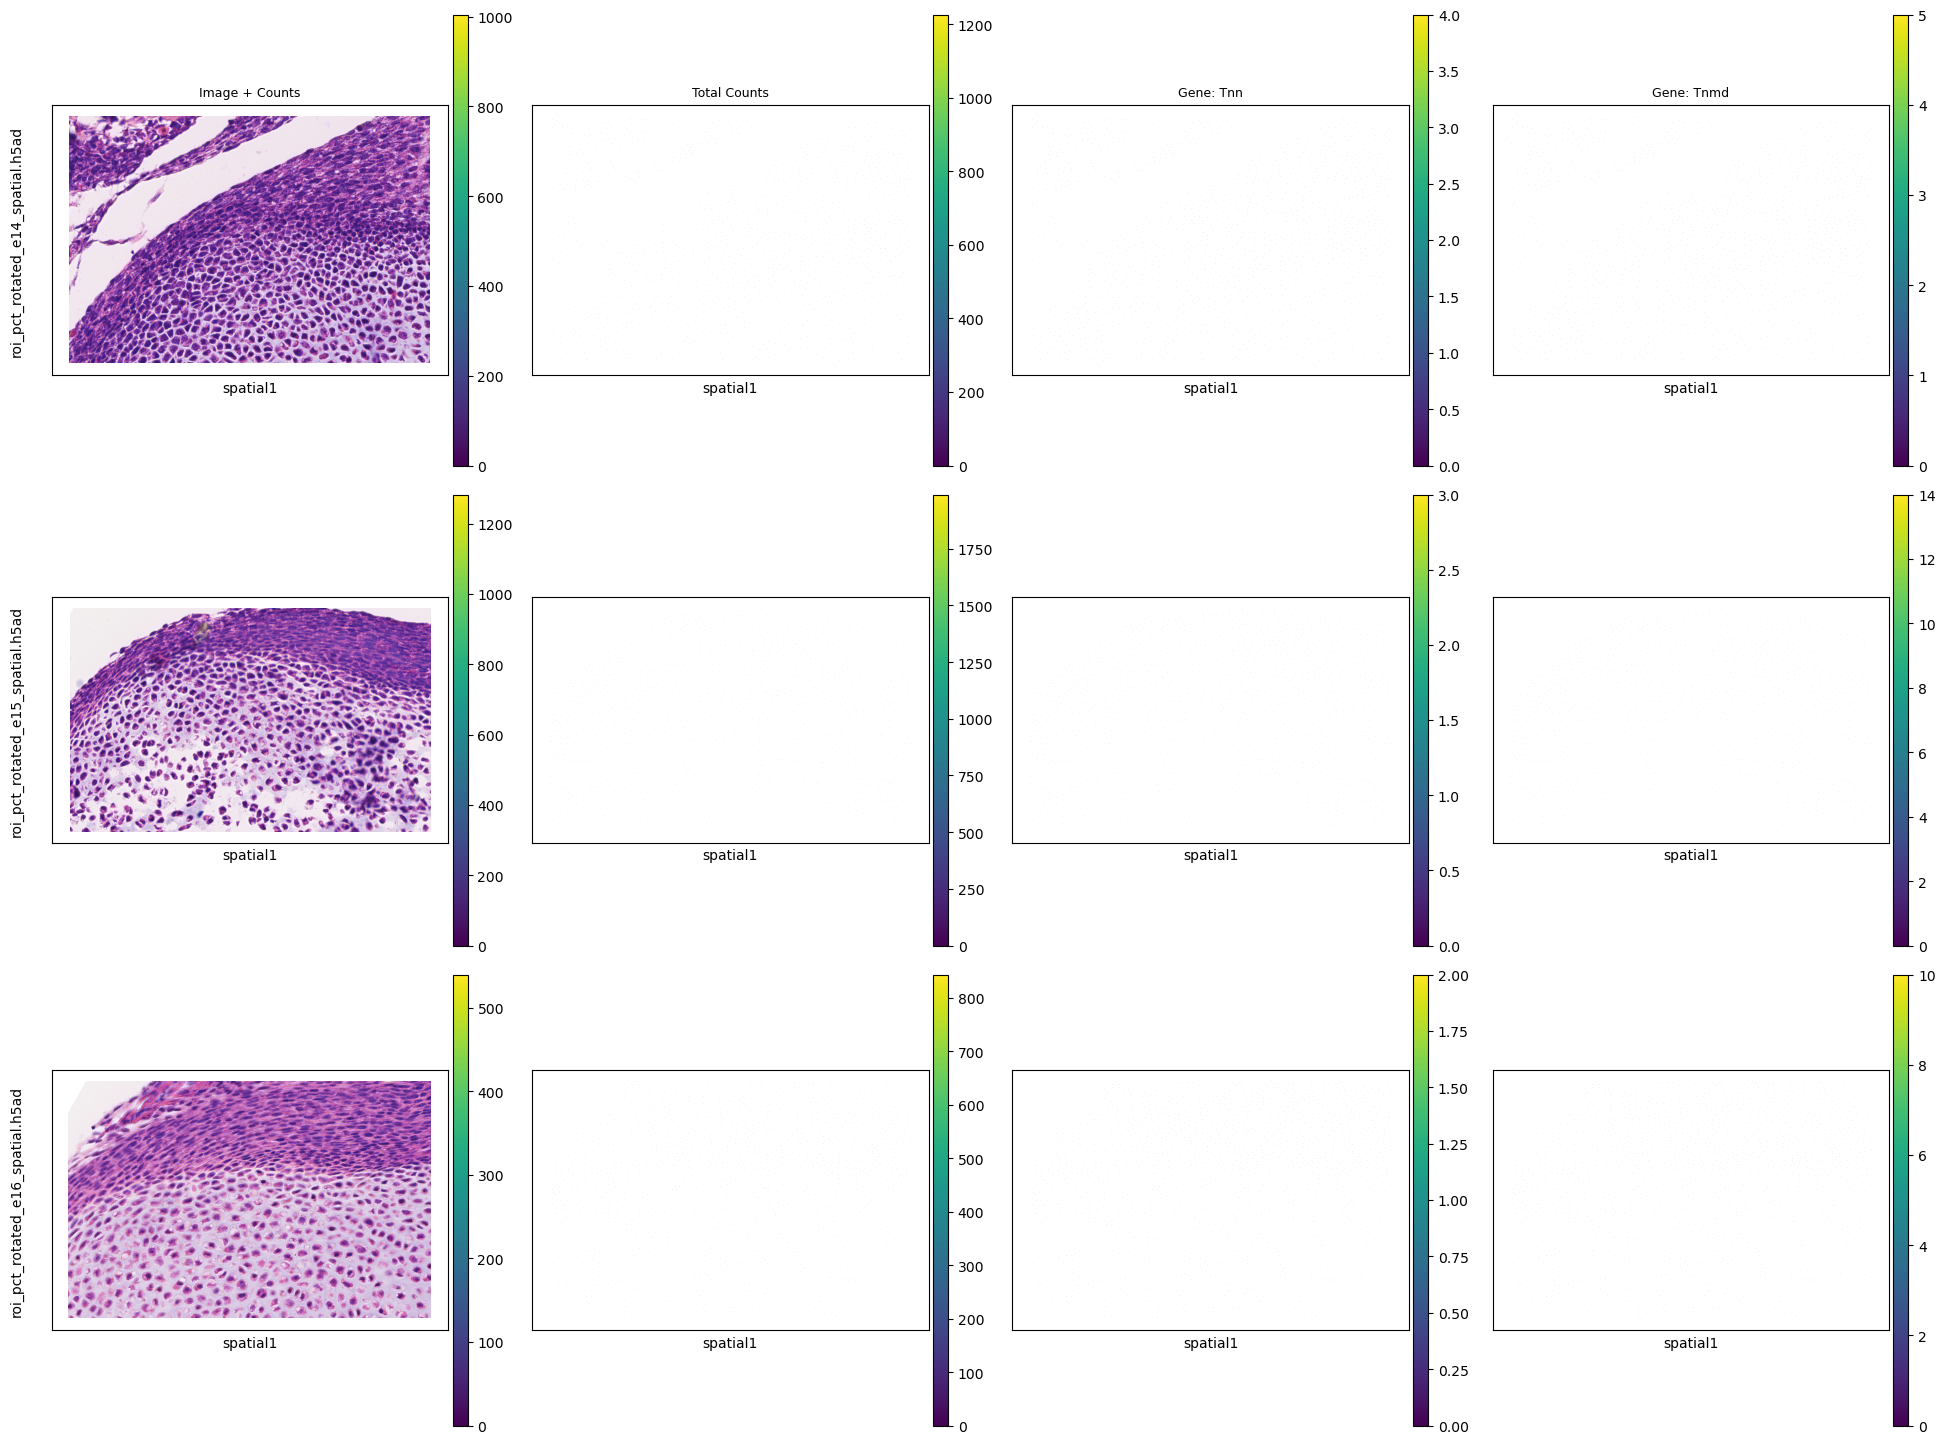

In [19]:
# --------------------------------------------------------------------------
# Step 6: Plot Subsetted Results (Multiple Views per Sample)
# --------------------------------------------------------------------------
print("\n--- Step 6: Displaying Subsetted Data (Multiple Views) ---")

num_samples = len(subset_adata_map)

if num_samples == 0:
    print("    No subset AnnData objects were loaded to plot.")
else:
    # --- Define the views/columns you want ---
    # <<< EDIT this list with the gene names you want to see >>>
    genes_to_plot = ["Tnn", "Tnmd"]
    # <<< END EDIT SECTION >>>

    # Define the plots for each column
    # View 0: Image + a default QC metric (e.g., n_genes_by_counts)
    # View 1: Total Counts (no image)
    # View 2+: Genes from genes_to_plot (no image)
    num_views = 2 + len(genes_to_plot)
    view_titles = ["Image + Counts", "Total Counts", *[f"Gene: {g}" for g in genes_to_plot]]

    # --- Create Figure Grid ---
    # Rows = number of samples, Columns = number of views
    ncols_sub = num_views
    nrows_sub = num_samples
    # Adjust figure size based on grid dimensions
    fig_width_sub = 5 * ncols_sub   # Base width per plot
    fig_height_sub = 5 * nrows_sub  # Base height per plot
    fig_sub, axes_sub = plt.subplots(nrows_sub, ncols_sub, figsize=(fig_width_sub, fig_height_sub), squeeze=False)

    # --- Loop through Samples (Rows) ---
    for i, (output_filename, adata_subset) in enumerate(subset_adata_map.items()):
        print(f"\n  Plotting Row {i+1}/{num_samples}: {output_filename}")

        # Ensure adata object is valid before proceeding
        if not isinstance(adata_subset, ad.AnnData):
             print(f"    Skipping {output_filename}, invalid AnnData object found.")
             # Optionally add error text to the first axis of the row
             if i < axes_sub.shape[0] and 0 < axes_sub.shape[1]:
                 axes_sub[i, 0].text(0.5, 0.5, "Error:\nInvalid\nAnnData", ha='center', va='center', color='red')
             continue

        try:
            # Get library ID (should exist after subsetting)
            library_id_sub = list(adata_subset.uns['spatial'].keys())[0]

            # --- Plot View 0: Image + n_genes_by_counts ---
            ax0 = axes_sub[i, 0] # Axis for row i, column 0
            print(f"    View 0: Image + n_genes_by_counts")
            if 'n_genes_by_counts' in adata_subset.obs:
                sc.pl.spatial(adata_subset, library_id=library_id_sub,
                              color=['n_genes_by_counts'], # Use a default QC metric
                              img_key='hires', # Show cropped image
                              spot_size=0.6, # Adjust spot size relative to cropped image
                              ax=ax0, show=False, title="", vmin=0)
            else:
                # Fallback if QC wasn't calculated on subset
                sc.pl.spatial(adata_subset, library_id=library_id_sub,
                              img_key='hires', spot_size=0.6,
                              ax=ax0, show=False, title="")
                ax0.text(0.5, 0.1, 'n_genes_by_counts\nnot found', ha='center', va='center',
                         transform=ax0.transAxes, fontsize=8, color='orange',
                         bbox=dict(facecolor='white', alpha=0.5, pad=0.1))
            # Set row label only on the first plot of the row
            ax0.set_ylabel(output_filename, fontsize=10, rotation=90, labelpad=20) # Add filename as row label
            ax0.yaxis.set_label_position("left")
            if i == 0: # Set column title only on the first row
                ax0.set_title(view_titles[0], fontsize=9)
            else:
                ax0.set_title("", fontsize=9)


            # --- Plot View 1: Total Counts (No Image) ---
            ax1 = axes_sub[i, 1] # Axis for row i, column 1
            print(f"    View 1: Total Counts (No Image)")
            if 'total_counts' in adata_subset.obs:
                sc.pl.spatial(adata_subset, library_id=library_id_sub,
                              color=['total_counts'], img_key=None, # No image
                              spot_size=1.0, # May need larger size w/o image background
                              ax=ax1, show=False, title="", vmin=0)
            else:
                 ax1.text(0.5, 0.5, 'total_counts\nnot found', ha='center', va='center', color='orange')
            # Hide Y label for subsequent plots in the row
            ax1.set_ylabel("")
            if i == 0: # Set column title only on the first row
                ax1.set_title(view_titles[1], fontsize=9)
            else:
                 ax1.set_title("", fontsize=9)

            # --- Plot Gene Views (No Image) ---
            for j, gene in enumerate(genes_to_plot):
                col_idx = 2 + j
                ax_gene = axes_sub[i, col_idx] # Axis for row i, column 2+j
                print(f"    View {col_idx}: Gene {gene} (No Image)")
                if gene in adata_subset.var_names:
                    sc.pl.spatial(adata_subset, library_id=library_id_sub,
                                  color=[gene], img_key=None, # No image
                                  spot_size=1.0, # Adjust size
                                  ax=ax_gene, show=False, title="")
                else:
                    print(f"      Warning: Gene '{gene}' not found in {output_filename}")
                    ax_gene.text(0.5, 0.5, f"Gene '{gene}'\nnot found", ha='center', va='center', color='orange')
                # Hide Y label
                ax_gene.set_ylabel("")
                if i == 0: # Set column title only on the first row
                    ax_gene.set_title(view_titles[col_idx], fontsize=9)
                else:
                    ax_gene.set_title("", fontsize=9)

        except Exception as e:
             print(f"    Error plotting row for {output_filename}: {e}")
             traceback.print_exc()
             # Add error text to the first subplot of the row for indication
             axes_sub[i, 0].cla() # Clear axis first
             axes_sub[i, 0].text(0.5, 0.5, f"Error\nplotting\n{output_filename}", ha='center', va='center', color='red')


    # --- Final Figure Touches ---
    # If you want an overall title uncomment the next line
    # fig_sub.suptitle("Verification of Subsetted Spatial Data", fontsize=16, y=0.99)
    plt.tight_layout(rect=[0.01, 0.01, 0.99, 0.98]) # Adjust rect tighter if suptitle is off
    plt.show()


--- Step 1: Loading Subset AnnData Objects and Images ---
  Attempting to load: roi_subset_h5ad/roi_pct_after_refined_rotated_e14_spatial.h5ad
    Loaded 'roi_pct_after_refined_rotated_e14_spatial.h5ad'. Shape: (1424, 19059)
      Checking loaded adata.X: dtype=float64, min=0.00, max=43.00
      Assigning Sample ID: e14
  Attempting to load: roi_subset_h5ad/roi_pct_rotated_e15_spatial.h5ad
    Loaded 'roi_pct_rotated_e15_spatial.h5ad'. Shape: (1636, 19059)
      Checking loaded adata.X: dtype=float64, min=0.00, max=154.00
      Assigning Sample ID: e15
  Attempting to load: roi_subset_h5ad/roi_pct_rotated_e16_spatial.h5ad
    Loaded 'roi_pct_rotated_e16_spatial.h5ad'. Shape: (1931, 19059)
      Checking loaded adata.X: dtype=float64, min=0.00, max=104.00
      Assigning Sample ID: e16

--- Step 2: Calculating Coordinate Offsets and Adjusting Coordinates ---
  Coordinate Offset for roi_pct_after_refined_rotated_e14_spatial.h5ad: (0, 0)
  Coordinate Offset for roi_pct_rotated_e15_spatia

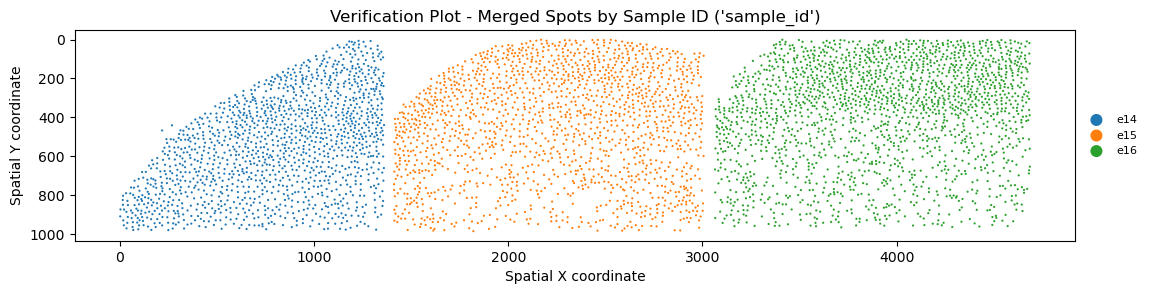


--- Spatial Merging Script Finished ---


In [30]:
# %% [markdown]
# # Merge RAW Spatial ROIs into a Single Spatial AnnData File & Export Image
#
# This notebook loads individual spatial ROI subset AnnData files (assumed to contain RAW counts),
# extracts a sample identifier (e.g., 'e14', 'e15') from the filename, adds this identifier
# to the observation metadata (`.obs`), stitches their images together horizontally onto a new canvas,
# adjusts the spot coordinates accordingly, combines the RAW expression data,
# and saves a new, single AnnData object with combined spatial information, sample IDs,
# the stitched canvas image as a separate file, and a CSV mapping of cell IDs to sample IDs.
#
# **NO additional QC, normalization, or processing is applied during this merge.**

# %%
# --- Imports ---
import anndata as ad
import scanpy as sc # Still needed for pl.scatter if used in verification
import os
import re # Needed for extracting sample ID
import numpy as np
import cv2 # Need OpenCV for image manipulation
import traceback
import pandas as pd
from scipy.sparse import issparse, vstack as sparse_vstack, csr_matrix # For stacking sparse matrices
import matplotlib.pyplot as plt # For saving image and plotting
# import matplotlib.ticker as mticker # Not needed if only plotting spots

# --- Configuration (Adjust these paths/names if needed) ---
# Directory where the individual ROI subset files are saved
# >>> IMPORTANT: These files should contain RAW COUNTS in .X <<<
subset_output_dir = "roi_subset_h5ad" # Or "split_tissue_h5ad" depending on previous script

# The prefix used for the subset filenames (e.g., "roi_pct_", "eX_")
# >>> Adjust prefix if necessary to match your subset filenames <<<
subset_output_prefix = "roi_pct_" # Or e.g., "e" if filenames are e13_spatial.h5ad

# List the *original* base filenames or the *exact* subset filenames
# This defines the order of stitching (left-to-right)
# Option 1: Using original base names (if prefix is consistent)
# original_base_filenames = [
#     "rotated_e14_spatial.h5ad",
#     "rotated_e15_spatial.h5ad",
#     "rotated_e16_spatial.h5ad",
# ]
# Make sure subset_output_prefix + base_filename matches the actual files.

# Option 2: Listing exact subset filenames (more robust if names vary)
# Make sure these filenames exist in subset_output_dir
subset_filenames_ordered = [
    "roi_pct_after_refined_rotated_e14_spatial.h5ad", # <<< Replace with your actual filenames in order
    "roi_pct_rotated_e15_spatial.h5ad",
    "roi_pct_rotated_e16_spatial.h5ad",
]


# --- Output Configuration ---
# Directory to save the final merged spatial file and the exported image
merged_output_dir = "merged_spatial_h5ad"
merged_anndata_filename = "merged_spatial_rois_RAW.h5ad" # Indicate RAW in name
merged_image_filename = "merged_spatial_rois_image.png" # Choose PNG or TIF(F)
# >>> NEW: Output filename for the Cell ID <-> Sample ID mapping <<<
mapping_csv_filename = "merged_cell_sample_mapping.csv"

merged_anndata_path = os.path.join(merged_output_dir, merged_anndata_filename)
merged_image_path = os.path.join(merged_output_dir, merged_image_filename)
# >>> NEW: Full path for the mapping CSV <<<
mapping_csv_path = os.path.join(merged_output_dir, mapping_csv_filename)


# Optional: Add padding between stitched images (in pixels)
padding = 50
canvas_background_color = (255, 255, 255) # White background (RGB)

# --- Create Output Directory ---
os.makedirs(merged_output_dir, exist_ok=True)

# --- Step 1: Load Subset AnnData Objects and Images ---
print("\n--- Step 1: Loading Subset AnnData Objects and Images ---")
adata_objects = {}
images = {}
scalefactors_dict = {}
original_metadata = {}
loaded_filenames_ordered = [] # Store names of files actually loaded in desired order
all_obs_list = []
all_coords_list = [] # Coordinates collected in Step 2
all_X_list = []

# Use the explicit list of subset filenames
for subset_filename in subset_filenames_ordered:
    subset_file_path = os.path.join(subset_output_dir, subset_filename)
    print(f"  Attempting to load: {subset_file_path}")
    if os.path.exists(subset_file_path):
        try:
            # Load AnnData - ASSUMES .X IS RAW COUNTS
            adata_sub = ad.read_h5ad(subset_file_path)
            print(f"    Loaded '{subset_filename}'. Shape: {adata_sub.shape}")
            print(f"      Checking loaded adata.X: dtype={adata_sub.X.dtype}, min={adata_sub.X.min():.2f}, max={adata_sub.X.max():.2f}")

            adata_objects[subset_filename] = adata_sub
            loaded_filenames_ordered.append(subset_filename)

            # Extract necessary spatial info
            if 'spatial' not in adata_sub.uns or not adata_sub.uns['spatial']: raise KeyError(".uns['spatial'] missing/empty.")
            library_id = list(adata_sub.uns['spatial'].keys())[0]
            if 'images' not in adata_sub.uns['spatial'][library_id] or 'hires' not in adata_sub.uns['spatial'][library_id]['images']: raise KeyError("hires image missing.")
            images[subset_filename] = adata_sub.uns['spatial'][library_id]['images']['hires']
            if not scalefactors_dict: scalefactors_dict = adata_sub.uns['spatial'][library_id].get('scalefactors', {}).copy() # Get scalefactors safely
            original_metadata[subset_filename] = adata_sub.uns['spatial'][library_id].get('metadata', {})
            if 'spatial' not in adata_sub.obsm: raise KeyError(".obsm['spatial'] missing.")

            # --- Prepare for merge (unique names, sample ID) ---
            match = re.search(r'(e\d+)', subset_filename)
            sample_id = match.group(1) if match else subset_filename.replace(".h5ad", "").replace(subset_output_prefix, "") # Fallback
            print(f"      Assigning Sample ID: {sample_id}")

            adata_sub.obs_names = f"{sample_id}_" + adata_sub.obs_names.astype(str)
            adata_sub.obs_names_make_unique()

            adata_sub.obs['sample_id'] = sample_id
            adata_sub.obs['sample_id'] = adata_sub.obs['sample_id'].astype('category')

            adata_sub.var_names_make_unique()

            all_obs_list.append(adata_sub.obs.copy())
            all_X_list.append(adata_sub.X)

        except Exception as e: print(f"    Error loading or processing {subset_filename}: {e}"); traceback.print_exc()
    else: print(f"    Warning: Subset file not found: {subset_file_path}")

if not adata_objects: print("\nError: No subset AnnData objects loaded. Cannot proceed."); exit()
if not scalefactors_dict: print("\nWarning: No scalefactors found in loaded subsets. Using defaults if needed.")


# --- Step 2: Calculate Coordinate Offsets and Adjust Coordinates ---
print("\n--- Step 2: Calculating Coordinate Offsets and Adjusting Coordinates ---")
current_x_offset = 0
num_loaded_images = len(loaded_filenames_ordered)
for i, subset_filename in enumerate(loaded_filenames_ordered):
     adata_sub = adata_objects[subset_filename]
     img_width = images[subset_filename].shape[1]
     y_offset = 0

     print(f"  Coordinate Offset for {subset_filename}: ({current_x_offset}, {y_offset})")
     original_coords = adata_sub.obsm['spatial']
     if not isinstance(original_coords, np.ndarray):
         original_coords = original_coords.to_numpy()

     adjusted_coords = original_coords.copy() + np.array([current_x_offset, y_offset])
     all_coords_list.append(adjusted_coords)

     if i < num_loaded_images - 1:
        current_x_offset += img_width + padding


# --- Step 3: Create Stitched Image Canvas ---
print("\n--- Step 3: Creating stitched image canvas ---")
total_width = 0
if loaded_filenames_ordered:
     for i, subset_filename in enumerate(loaded_filenames_ordered):
          img_width = images[subset_filename].shape[1]
          total_width += img_width
          if i < num_loaded_images - 1: total_width += padding
else:
     print("No images loaded to stitch.")

max_height = 0
if images: max_height = max(img.shape[0] for img in images.values())

print(f"  Canvas Dimensions (H x W): {max_height} x {total_width}")
canvas = np.full((max_height, total_width, 3), canvas_background_color, dtype=np.uint8) if max_height > 0 and total_width > 0 else None

current_x_placement_offset = 0
if canvas is not None:
    for i, subset_filename in enumerate(loaded_filenames_ordered):
        img = images[subset_filename]; h, w = img.shape[:2]; y_offset_place = 0
        print(f"  Placing '{subset_filename}' at canvas X offset: {current_x_placement_offset}")
        # Image conversion logic...
        if img.dtype != np.uint8:
            print(f"    Warning: Converting image for {subset_filename} from {img.dtype} to uint8.")
            img = img.astype(np.float32)
            img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
            img = img.astype(np.uint8)

        if img.ndim == 2: img_to_place = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4: img_to_place = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        elif img.shape[2] == 3: img_to_place = img
        else:
             print(f"    ERROR: Unsupported image channel count ({img.shape}) for {subset_filename}. Skipping placement.")
             continue

        x_start, x_end = current_x_placement_offset, current_x_placement_offset + w
        y_start, y_end = y_offset_place, y_offset_place + h
        if x_end <= canvas.shape[1] and y_end <= canvas.shape[0]:
            canvas[y_start:y_end, x_start:x_end, :] = img_to_place
        else: print(f"    ERROR: Slice out of bounds. Skipping placement.")

        if i < num_loaded_images - 1: current_x_placement_offset += w + padding
    print("  Image stitching complete.")
    print(f"    Canvas Check (After Stitch): dtype={canvas.dtype}, min={np.min(canvas)}, max={np.max(canvas)}")
else: print("  Canvas creation skipped.")


# --- Step 4: Combine Data and Create Merged AnnData ---
print("\n--- Step 4: Combining data and creating merged AnnData ---")

# Combine Observations
combined_obs = pd.concat(all_obs_list, axis=0, ignore_index=False) if all_obs_list else None
if combined_obs is not None:
    print(f"  Combined obs shape: {combined_obs.shape}")
    if 'sample_id' in combined_obs.columns:
        print(f"  Sample IDs found in combined obs: {combined_obs['sample_id'].unique().tolist()}")
    else:
        print("  WARNING: 'sample_id' column missing from combined obs!")
else: print("  ERROR: Failed to combine obs.")

# Combine Coordinates
combined_coords = np.vstack(all_coords_list) if all_coords_list else None
if combined_coords is not None: print(f"  Combined coords shape: {combined_coords.shape}")
else: print("  ERROR: Failed to combine coords.")

# Combine Expression Matrices
combined_X = None
if all_X_list:
     try:
          is_sparse = any(issparse(m) for m in all_X_list)
          print(f"    Attempting X combination for {len(all_X_list)} matrices (Sparse={is_sparse})...")
          matrices_to_stack = []
          for m in all_X_list:
              if m is None: continue
              if issparse(m): matrices_to_stack.append(m.tocsr())
              elif isinstance(m, np.ndarray): matrices_to_stack.append(csr_matrix(m))
              else: raise TypeError(f"Unsupported matrix type: {type(m)}")

          if matrices_to_stack:
             combined_X = sparse_vstack(matrices_to_stack, format='csr')
             print(f"    Combined X shape: {combined_X.shape}")
          else: combined_X = None

     except Exception as e: print(f"ERROR Combining X: {e}"); traceback.print_exc(); combined_X = None
else: print("  ERROR: No X matrices collected.")

# Get Variable annotations
combined_var = None
if loaded_filenames_ordered and loaded_filenames_ordered[0] in adata_objects:
     try:
          first_key = loaded_filenames_ordered[0]
          combined_var = adata_objects[first_key].var.copy()
          combined_var.index.name = None
          combined_var.index = ad.utils.make_index_unique(combined_var.index.astype(str))
          print(f"  Using variable annotations from '{first_key}'. Var shape: {combined_var.shape}")
     except Exception as e: print(f"ERROR getting var: {e}"); combined_var = None
else: print("  ERROR: Cannot get var annotations.")

# Create Merged AnnData
adata_merged_spatial = None
if combined_X is not None and combined_obs is not None and combined_var is not None and combined_coords is not None and canvas is not None and scalefactors_dict:
    print("\n  Creating final AnnData object with RAW counts in .X ...")
    try:
        n_obs_X, n_vars_X = combined_X.shape
        n_obs_obs = combined_obs.shape[0]
        n_vars_var = combined_var.shape[0]
        n_obs_coords = combined_coords.shape[0]
        print(f"    Shape check: X=({n_obs_X},{n_vars_X}), obs=({n_obs_obs}, ...), var=({n_vars_var}, ...), coords=({n_obs_coords}, ...)")
        if not (n_obs_X == n_obs_obs == n_obs_coords): raise ValueError(f"Inconsistent observations: X={n_obs_X}, obs={n_obs_obs}, coords={n_obs_coords}")
        if not (n_vars_X == n_vars_var): raise ValueError(f"Inconsistent variables: X={n_vars_X}, var={n_vars_var}")

        adata_merged_spatial = ad.AnnData(X=combined_X, obs=combined_obs, var=combined_var, obsm={'spatial': combined_coords})
        print(f"    AnnData object created. Shape: {adata_merged_spatial.shape}")

        merged_library_id = "stitched_rois_raw"
        adata_merged_spatial.uns['spatial'] = {}
        adata_merged_spatial.uns['spatial'][merged_library_id] = {
            'images': {'hires': canvas},
            'scalefactors': scalefactors_dict,
            'metadata': {
                'comment': 'Merged spatial ROIs (RAW counts) via horizontal stitching.',
                'padding_pixels': padding,
                'original_files_metadata': original_metadata
             }
        }
        print("    uns['spatial'] structure created.")
        final_image = adata_merged_spatial.uns['spatial'][merged_library_id]['images']['hires']
        print(f"    Final Image Check: dtype={final_image.dtype}, min={np.min(final_image)}, max={np.max(final_image)}")

    except Exception as e:
        print(f"\nERROR: Failed to create/finalize AnnData object: {e}"); traceback.print_exc()
        adata_merged_spatial = None
else:
    print("\nERROR: One or more required components missing/failed. Cannot create merged AnnData.")
    print(f"  Status: combined_X={'OK' if combined_X is not None else 'FAIL'}, "
          f"combined_obs={'OK' if combined_obs is not None else 'FAIL'}, "
          f"combined_var={'OK' if combined_var is not None else 'FAIL'}, "
          f"combined_coords={'OK' if combined_coords is not None else 'FAIL'}, "
          f"canvas={'OK' if canvas is not None else 'FAIL'}, "
          f"scalefactors_dict={'OK' if scalefactors_dict else 'FAIL'}")


# --- Step 5: Save Merged Spatial AnnData, Export Image, and Export Mapping ---

# 5a: Save AnnData
if adata_merged_spatial is not None:
    print("\n--- Step 5a: Saving merged spatial AnnData (RAW counts in .X) ---")
    try:
        adata_merged_spatial.write(merged_anndata_path, compression="gzip")
        print(f"  Successfully saved merged AnnData to: {merged_anndata_path}")
    except Exception as e:
        print(f"  Error saving merged AnnData: {e}"); traceback.print_exc()
else:
     print("\n--- Step 5a: Skipping AnnData save (object not created) ---")

# 5b: Export image
if canvas is not None:
     print("\n--- Step 5b: Exporting stitched canvas image ---")
     try:
        plt.imsave(merged_image_path, canvas)
        print(f"  Successfully exported stitched image to: {merged_image_path}")
     except Exception as save_e:
        print(f"  Error exporting image using matplotlib: {save_e}"); traceback.print_exc()
        try:
            print("    Attempting fallback save with OpenCV...")
            success = cv2.imwrite(merged_image_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
            if success: print(f"  Successfully exported stitched image using OpenCV to: {merged_image_path}")
            else: print(f"  OpenCV fallback save also failed.")
        except Exception as cv_e: print(f"  Error during OpenCV fallback save: {cv_e}")
else:
     print("\n--- Step 5b: Skipping image export (canvas not created) ---")

# >>> NEW: Step 5c: Export Cell ID to Sample ID mapping <<<
if adata_merged_spatial is not None and 'sample_id' in adata_merged_spatial.obs:
    print("\n--- Step 5c: Exporting Cell ID to Sample ID mapping ---")
    try:
        # Create a DataFrame with cell IDs (obs_names) and sample IDs
        mapping_df = pd.DataFrame({
            'cell_id': adata_merged_spatial.obs_names,
            'sample_id': adata_merged_spatial.obs['sample_id']
        })
        # Save to CSV without the DataFrame index
        mapping_df.to_csv(mapping_csv_path, index=False, sep=',')
        print(f"  Successfully exported cell/sample mapping to: {mapping_csv_path}")
        print(f"    Mapping file shape: {mapping_df.shape}")
        print(f"    Mapping file head:\n{mapping_df.head().to_string()}") # Show first few lines
    except Exception as e:
        print(f"  Error exporting cell/sample mapping: {e}"); traceback.print_exc()
elif adata_merged_spatial is None:
     print("\n--- Step 5c: Skipping mapping export (AnnData object not created) ---")
else: # AnnData exists but sample_id column is missing
     print("\n--- Step 5c: Skipping mapping export ('sample_id' column not found in AnnData .obs) ---")


# --- Step 6: Optional Verification Plot (Spots Only Recommended) ---
print("\n--- Step 6: Optional Verification Plot (Spots Only) ---")
if os.path.exists(merged_anndata_path):
    try:
        print(f"  Loading merged spatial data from: {merged_anndata_path}")
        adata_plot = ad.read_h5ad(merged_anndata_path)
        print(f"    Loaded AnnData shape for plot: {adata_plot.shape}")
        print(f"    Available .obs columns: {adata_plot.obs.columns.tolist()}")

        if 'spatial' not in adata_plot.obsm: raise KeyError(".obsm['spatial'] not found.")
        if 'sample_id' not in adata_plot.obs: raise KeyError(".obs['sample_id'] not found. Cannot color by sample.")

        coords_plot = adata_plot.obsm['spatial']
        adata_plot.obs['spatial_x'] = coords_plot[:, 0]
        adata_plot.obs['spatial_y'] = coords_plot[:, 1]

        color_variable = 'sample_id'
        print(f"    Using '{color_variable}' for spot colors.")
        print(f"    Unique values in '{color_variable}': {adata_plot.obs[color_variable].unique().tolist()}")

        fig_verify, ax_verify = plt.subplots(figsize=(14, 8))

        print("    Plotting spots using pl.scatter (no background image)...")
        spot_size_pixels = 10
        scatter_params = {
            'adata': adata_plot, 'x': 'spatial_x', 'y': 'spatial_y',
            'color': color_variable, 'ax': ax_verify, 'show': False,
            'title': "",
            'size': spot_size_pixels,
            'legend_loc': 'right margin',
            'legend_fontsize': 8
        }
        sc.pl.scatter(**scatter_params)

        ax_verify.invert_yaxis()
        ax_verify.set_aspect('equal', adjustable='box')

        ax_verify.set_xlabel("Spatial X coordinate")
        ax_verify.set_ylabel("Spatial Y coordinate")
        ax_verify.set_title(f"Verification Plot - Merged Spots by Sample ID ('{color_variable}')", fontsize=12)

        legend_margin = 0.85
        fig_verify.tight_layout(rect=[0.02, 0.03, legend_margin, 0.97])

        plt.show()
        del adata_plot

    except Exception as e: print(f"  Error generating verification plot: {e}"); traceback.print_exc()
else: print("  Merged AnnData file not found, skipping verification plot.")

print("\n--- Spatial Merging Script Finished ---")

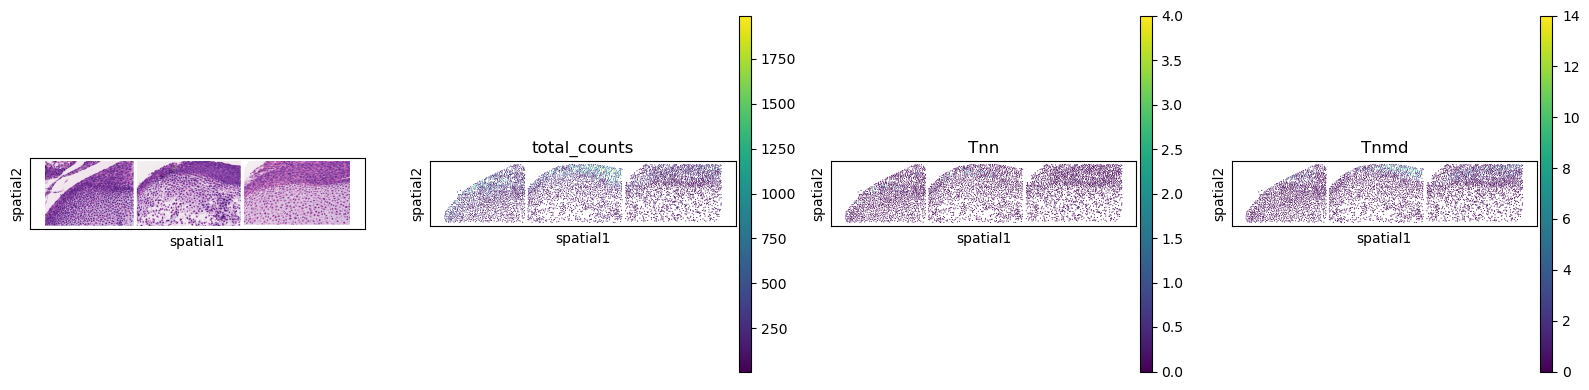

In [32]:
# 加载数据
roi_adata = ad.read_h5ad("./merged_spatial_h5ad/merged_spatial_rois_RAW.h5ad")
# 可视化验证
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sc.pl.spatial(roi_adata, ax=axes[0], 
              show=False)
sc.pl.spatial(roi_adata, ax=axes[1], 
              color=["total_counts"],
              img_key = None,
              show=False)
sc.pl.spatial(roi_adata, ax=axes[2], 
              color=['Tnn'],
              img_key = None,
              #spot_size=1,
              show=False)
sc.pl.spatial(roi_adata, ax=axes[3], 
              color=['Tnmd'],
              img_key = None,
              #spot_size=1,
              show=False)
plt.tight_layout()
plt.tight_layout()
plt.show()
